In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")


## Simulate Qubit
We take the qubit from Elie Genois - Quantum-tailored readout strategies for quantum error correction - DOI:https://doi.org/10.1103/PRXQuantum.2.040355


In [2]:
## Setup parameters:
simulation_steps = 1001

# Setup Qubit, Resonator and Coupling
qubit_states    = 3
n_cutoff        = 15
EJ              = 10 * 2 * np.pi # h GHz
EC              = EJ / 25

resonator_states        = 10
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.015
driving_time           = (0, 1000)
# drive_function         = lam'bda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)


# Loss parameters:
# Setup the qubit decay
rate_qubit_decay  = 1 / 10_000 # ns # 1 / 15000
rate_qubit_excite = 0.0

readout_photon_rate = 0.1
readout_efficiency  = 1


# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()


# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [3]:
# Derived quantities

# Calculate all types of constants, which is useful for further analysis:
omega_01 = H_qubit.diag()[1] - H_qubit.diag()[0]
omega_02 = H_qubit.diag()[2] - H_qubit.diag()[0]
omega_12 = H_qubit.diag()[2] - H_qubit.diag()[1]

# Calculate the dispersive shifts
# Multi qubit shifts
g_squared_matrix    = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix     = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r             = resonator_frequency

# The Chi-matrix
chi_matrix          = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts   = chi_matrix.sum(axis = 1) / 2 / np.pi


# Omega resonator for qubits
omega_resonator_qubit = resonator_frequency + dispersive_shifts

## Define Hamiltonian:

Non interacting:  

$H_{eff} = (\omega_r - \omega_d  + \sum_k \chi_k \ket{k}\bra{k} ) a^\dagger a$

Driving

$H_{d, eff} = \epsilon (a^\dagger + a)$

In [4]:
from qutip import tensor

# Drive inbetween the two qubit states
drive_frequency = (omega_resonator_qubit[0] + omega_resonator_qubit[1]) / 2 

# Define the Hamiltonian components. 
H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)
H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)
H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

H =  H_res + H_disp + H_drive

## Deterministic Simulation

In [5]:
from qutip import ket2dm, operator_to_vector, create

# Initial_states
ground_resonator_state = qutip.basis(resonator_states, 0)
ground_qubit_state     = qutip.basis(qubit_states, 0)
excited_qubit_state    = qutip.basis(qubit_states, 1)

# Define operators

## Collapse Operators
# Qubit decay
qubit_decay_operator    = np.sqrt(rate_qubit_decay)     * destroy(qubit_states)
qubit_excite_operator   = np.sqrt(rate_qubit_excite)    * create(qubit_states)

# Resonator decay
resonator_decay_operator = np.sqrt(readout_photon_rate) * destroy(resonator_states)

# Define the collapse operators
c_ops = [
    tensor(qubit_decay_operator,        qutip.qeye(resonator_states)),
    tensor(qubit_excite_operator,       qutip.qeye(resonator_states)),
    tensor(qutip.qeye(qubit_states),    resonator_decay_operator)
]

## Expectation Operators
# Qubit Occupation
qubit_occupation_operator = qutip.num(qubit_states)

# Resonator Occupation
resonator_occupation_operator = qutip.num(resonator_states)

resonator_I = a + a_dag
resonator_Q = 1j * (a - a_dag)

# Define the collapse operators
e_ops = [
    tensor(qubit_occupation_operator, qutip.qeye(resonator_states)),
    tensor(qutip.qeye(qubit_states), resonator_occupation_operator),
    tensor(qutip.qeye(qubit_states), resonator_I),
    tensor(qutip.qeye(qubit_states), resonator_Q)
]


In [6]:
# Simulation
from qutip import mesolve

# Define the time steps
tlist = np.linspace(driving_time[0], driving_time[1], simulation_steps)

# Run the simulation
result_ground = mesolve(
    H,
    tensor(ground_qubit_state, ground_resonator_state),
    tlist,
    c_ops = c_ops,
    e_ops = e_ops,
    progress_bar = True
)

result_excited = mesolve(
    H,
    tensor(excited_qubit_state, ground_resonator_state),
    tlist,
    c_ops = c_ops,
    e_ops = e_ops,
    progress_bar = True
)


10.1%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.04s. Est. time left: 00:00:00:00
40.1%. Run time:   0.06s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.10s. Est. time left: 00:00:00:00
90.0%. Run time:   0.11s. Est. time left: 00:00:00:00
Total run time:   0.13s
10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.02s. Est. time left: 00:00:00:00
30.1%. Run time:   0.04s. Est. time left: 00:00:00:00
40.1%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.10s. Est. time left: 00:00:00:00
90.0%. Run time:   0.11s. Est. time left: 00:00:00:00
Tota

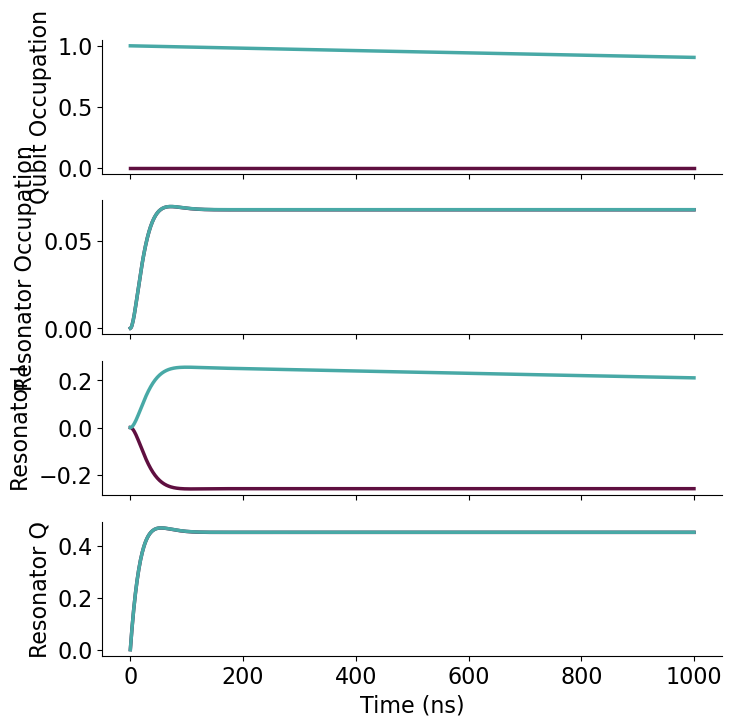

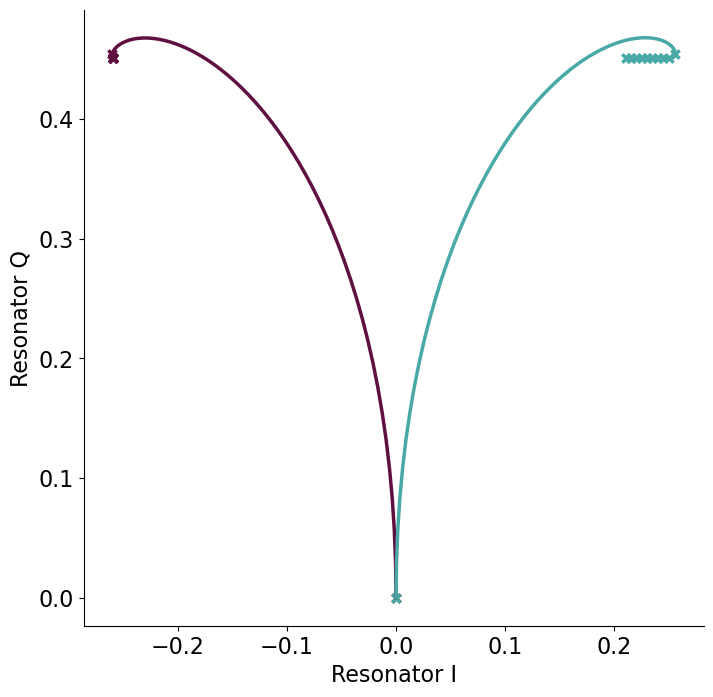

In [7]:
# Plotting the expectation values in 2 times 2 grid
def plot_expectation_values(result_ground, result_excited, tlist):

    fig, ax = plt.subplots(nrows = 4, figsize = (8, 8), sharex = True)

    ax[0].plot(tlist, result_ground.expect[0], label = "Ground")
    ax[0].plot(tlist, result_excited.expect[0], label = "Excited")
    ax[0].set_ylabel("Qubit Occupation")

    ax[1].plot(tlist, result_ground.expect[1])
    ax[1].plot(tlist, result_excited.expect[1])
    ax[1].set_ylabel("Resonator Occupation")

    ax[2].plot(tlist, result_ground.expect[2])
    ax[2].plot(tlist, result_excited.expect[2])
    ax[2].set_ylabel("Resonator I")

    ax[3].plot(tlist, result_ground.expect[3])
    ax[3].plot(tlist, result_excited.expect[3])
    ax[3].set_ylabel("Resonator Q")

    ax[3].set_xlabel("Time (ns)")

    return fig, ax

def plot_IQ_trajectory(ground_IQ, excited_IQ, plot_every = None, alpha_line = 1):
        fig, ax = plt.subplots(nrows = 1, figsize = (8, 8), sharex = True)
    
        ax.plot(ground_IQ[0],  ground_IQ[1],  label = "Ground", alpha = alpha_line)
        ax.plot(excited_IQ[0], excited_IQ[1], label = "Excited", alpha = alpha_line)
        ax.set_xlabel("Resonator I")
        ax.set_ylabel("Resonator Q")

        if plot_every:
            ax.scatter(ground_IQ[0][::plot_every],  ground_IQ[1][::plot_every],  marker = "x", color = "C0")
            ax.scatter(excited_IQ[0][::plot_every], excited_IQ[1][::plot_every], marker = "x", color = "C1")
    
        return fig, ax

fig_deterministic_exp, ax_deterministic_exp = plot_expectation_values(result_ground, result_excited, tlist)
fig_deterministic_IQ,  ax_deterministic_IQ  = plot_IQ_trajectory(result_ground.expect[2:], result_excited.expect[2:], plot_every = 100)


## Stochastic Simulation

In [8]:
from qutip import vector_to_operator, lindblad_dissipator, spre, spost, liouvillian, qeye
from qutip.expect import expect_rho_vec



qubit_decay =         tensor(qubit_decay_operator,        qutip.qeye(resonator_states)),
qubit_excitation =    tensor(qubit_excite_operator,       qutip.qeye(resonator_states)),
photon_decay =        tensor(qutip.qeye(qubit_states),    resonator_decay_operator)


# Define the deterministic part of the Hamiltonian
L = liouvillian(H)
D1 = lindblad_dissipator(tensor(qubit_decay_operator,        qutip.qeye(resonator_states)))
D2 = lindblad_dissipator(tensor(qubit_excite_operator,       qutip.qeye(resonator_states)))
D_from_measurement = lindblad_dissipator(tensor(qutip.qeye(qubit_states),    resonator_decay_operator))

evolution_operator = L + D1 + D2 + D_from_measurement

def evolution(time, rho_vec):
    return (L + D1 + D2 + D_from_measurement) * rho_vec


# Define the Stochastic Part giving rise to the noise/measurements

measure_quadrature_1 = np.sqrt(readout_photon_rate) *      tensor(qeye(qubit_states), a)
measure_quadrature_2 = np.sqrt(readout_photon_rate) * 1j * tensor(qeye(qubit_states), a)

super_operator_1 = spre(2 * measure_quadrature_1 / 2) + spost(measure_quadrature_1.dag())
super_operator_2 = spre(2 * measure_quadrature_2 / 2) + spost(measure_quadrature_2.dag())

def measurement_evolution(time, rho_vec):
    expect1 = expect_rho_vec(super_operator_1.data, rho_vec, False)
    expect2 = expect_rho_vec(super_operator_2.data, rho_vec, False)
    drho1   = super_operator_1 * rho_vec - expect1 * rho_vec
    drho2   = super_operator_2 * rho_vec - expect2 * rho_vec
    return np.vstack([drho1, drho2])


# Expectations and measurements
e_vals_stochastic = [spre(operator) for operator in e_ops]
m_vals_stochastic = [np.sqrt(2 / readout_photon_rate) * spre(operator + operator.dag())  for operator in [measure_quadrature_1, measure_quadrature_2]]
dW_factors        = [1] # np.sqrt(2 / readout_photon_rate / 8), np.sqrt(2 / readout_photon_rate / 8)]

In [9]:
inital_ground_state     = operator_to_vector(ket2dm(tensor(ground_qubit_state, ground_resonator_state)))
inital_excited_state    = operator_to_vector(ket2dm(tensor(excited_qubit_state, ground_resonator_state)))

In [11]:
import torch

# from torchdiffeq import odeint

In [24]:
def operator_to_sparse_tensor(operator):
    sprase_tensor =  torch.sparse_coo_tensor(
        indices = torch.tensor(operator.data.nonzero()),
        values = torch.tensor(operator.data.data),
        size = operator.data.shape
    )
    return sprase_tensor.type(torch.complex64)

L_tensor  = operator_to_sparse_tensor(L).to_dense()
D1_tensor = operator_to_sparse_tensor(D1).to_dense()
D2_tensor = operator_to_sparse_tensor(D2).to_dense()

evolution_operator = L_tensor + D1_tensor + D2_tensor

initial_ground_state_tensor = operator_to_sparse_tensor(inital_ground_state).to_dense()

tlist_tensor = torch.tensor(tlist[:100])

In [25]:
initial_ground_state_tensor = initial_ground_state_tensor.repeat(25, 1, 1).squeeze(2)

In [29]:
import torchsde
class StochasticEvolution(torch.nn.Module):
    def __init__(self, L_tensor, D1_tensor, D2_tensor):
        super(StochasticEvolution, self).__init__()
        self.L_tensor  = L_tensor
        self.D1_tensor = D1_tensor
        self.D2_tensor = D2_tensor

        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):
        return torch.squeeze((self.L_tensor + self.D1_tensor + self.D2_tensor) @ y.unsqueeze(2), -1) 
    
    def g(self, t, y):
        return y * 0

def ode_func(t, x):
    return torch.squeeze((L_tensor + D1_tensor + D2_tensor) @ x.unsqueeze(2), -1)    

sde = StochasticEvolution(L_tensor, D1_tensor, D2_tensor)
sde = torch.compile(sde)

In [48]:
dt = 1
ys = []
y  = initial_ground_state_tensor
for i in range(1000):
    y += dt * sde.f(i , y)
    ys.append(y)


In [53]:
torch.einsum("tijj->ti", torch.stack(ys))

RuntimeError: einsum(): the number of subscripts in the equation (4) does not match the number of dimensions (3) for operand 0 and no ellipsis was given

In [42]:
torch.einsum("itjj -> it", torch.stack(ys).reshape(100, 25, 30, 30))

tensor([[1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j],
        [1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j],
        [1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j],
        ...,
        [1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j],
        [1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j],
        [1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j,  ...,
         1.-3.7848e-09j, 1.-3.7848e-09j, 1.-3.7848e-09j]])

In [176]:
y.shape

torch.Size([5, 25, 900])

In [161]:
torch.einsum("tijj -> ti", y.to_dense().reshape(-1, 25, 30, 30))

RuntimeError: shape '[-1, 25, 30, 30]' is invalid for input of size 4500

In [125]:
from qutip import general_stochastic, parallel_map

result_ground_stochastic = general_stochastic(
    operator_to_vector(ket2dm(tensor(ground_qubit_state, ground_resonator_state))),
    tlist,
    evolution,
    measurement_evolution,
    ntraj = 10,
    nsubsteps = 5,
    e_ops = e_vals_stochastic,
    m_ops = m_vals_stochastic,
    dW_factors = dW_factors,
    len_d2 = 2, 
    progress_bar = True,
    solver = "platen",
    store_measurement = True,
    map_func = parallel_map    
)

result_excited_stochastic = general_stochastic(
    operator_to_vector(ket2dm(tensor(excited_qubit_state, ground_resonator_state))),
    tlist,
    evolution,
    measurement_evolution,
    ntraj = 10,
    nsubsteps = 5,
    e_ops = e_vals_stochastic,
    m_ops = m_vals_stochastic,
    dW_factors = dW_factors,
    len_d2 = 2,
    progress_bar = True,
    solver = "platen",
    store_measurement = True,
    map_func = parallel_map
)


10.0%. Run time:  69.21s. Est. time left: 00:00:10:22
20.0%. Run time:  82.10s. Est. time left: 00:00:05:28
30.0%. Run time:  82.41s. Est. time left: 00:00:03:12
40.0%. Run time:  82.84s. Est. time left: 00:00:02:04
50.0%. Run time:  83.02s. Est. time left: 00:00:01:23
60.0%. Run time:  85.31s. Est. time left: 00:00:00:56
70.0%. Run time:  85.73s. Est. time left: 00:00:00:36
80.0%. Run time:  87.60s. Est. time left: 00:00:00:21
90.0%. Run time:  88.51s. Est. time left: 00:00:00:09
100.0%. Run time:  89.81s. Est. time left: 00:00:00:00
Total run time:  89.83s
10.0%. Run time:  64.97s. Est. time left: 00:00:09:44
20.0%. Run time:  74.87s. Est. time left: 00:00:04:59
30.0%. Run time:  78.08s. Est. time left: 00:00:03:02
40.0%. Run time:  80.32s. Est. time left: 00:00:02:00
50.0%. Run time:  81.14s. Est. time left: 00:00:01:21
60.0%. Run time:  81.45s. Est. time left: 00:00:00:54
70.0%. Run time:  81.87s. Est. time left: 00:00:00:35
80.0%. Run time:  82.26s. Est. time left: 00:00:00:20
90.

(<Figure size 800x800 with 4 Axes>,
 array([<AxesSubplot:ylabel='Qubit Occupation'>,
        <AxesSubplot:ylabel='Resonator Occupation'>,
        <AxesSubplot:ylabel='Resonator I'>,
        <AxesSubplot:xlabel='Time (ns)', ylabel='Resonator Q'>],
       dtype=object))

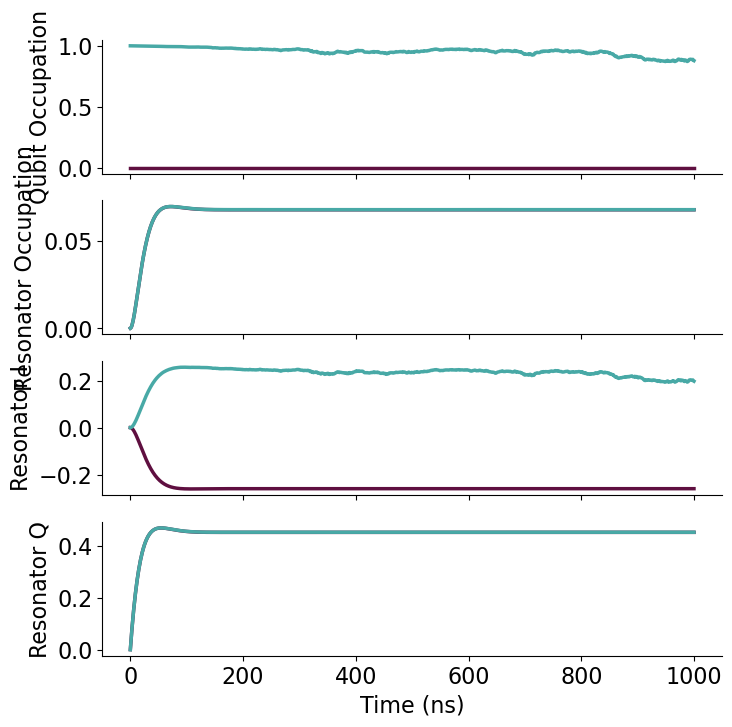

In [171]:
plot_expectation_values(result_ground_stochastic, result_excited_stochastic, tlist)


In [172]:
tlist

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

ValueError: x and y must have same first dimension, but have shapes (1001,) and (2002,)

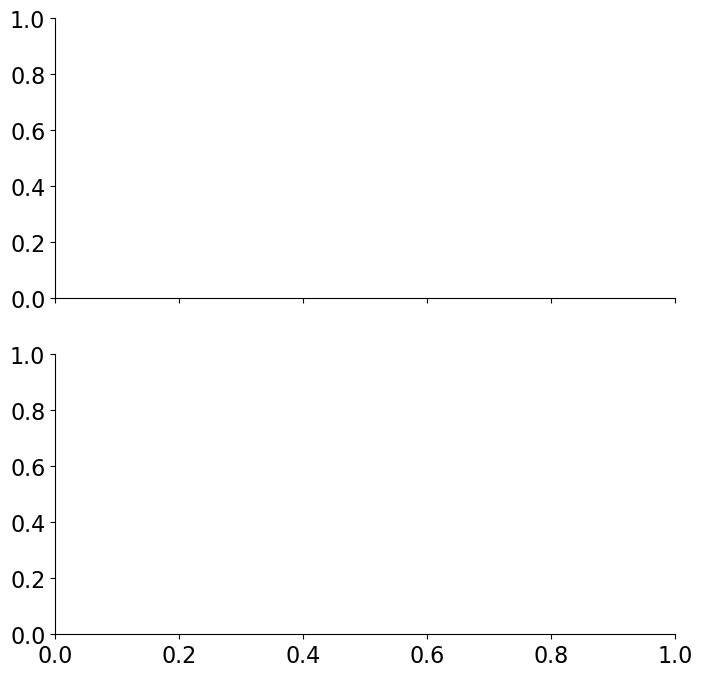

In [173]:
fig, axes = plt.subplots(nrows = 2, figsize = (8, 8), sharex = True)


def rolling_mean(array, window = 250):
    return np.cumsum(array)
    return np.convolve(array, np.ones(window) / window, mode = "same")


for i in range(result_ground_stochastic.ntraj):
    axes[0].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_ground_stochastic.measurement[i][:, 0]),  color = "C0", alpha = 0.25)
    axes[0].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_excited_stochastic.measurement[i][:, 0]), color = "C1", alpha = 0.25)

    axes[1].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_ground_stochastic.measurement[i][:, 1]),  color = "C0", alpha = 0.25)
    axes[1].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_excited_stochastic.measurement[i][:, 1]), color = "C1", alpha = 0.25)

axes[0].plot(tlist, rolling_mean(result_ground_stochastic.expect[2]),  color = "C0", label = "Ground")
axes[0].plot(tlist, rolling_mean(result_excited_stochastic.expect[2]), color = "C1", label = "Excited")

axes[1].plot(tlist, rolling_mean(result_ground_stochastic.expect[3]),  color = "C0", label = "Ground")
axes[1].plot(tlist, rolling_mean(result_excited_stochastic.expect[3]), color = "C1", label = "Excited")

In [174]:
result_ground_stochastic.measurement[0].shape

(1001, 1, 2)

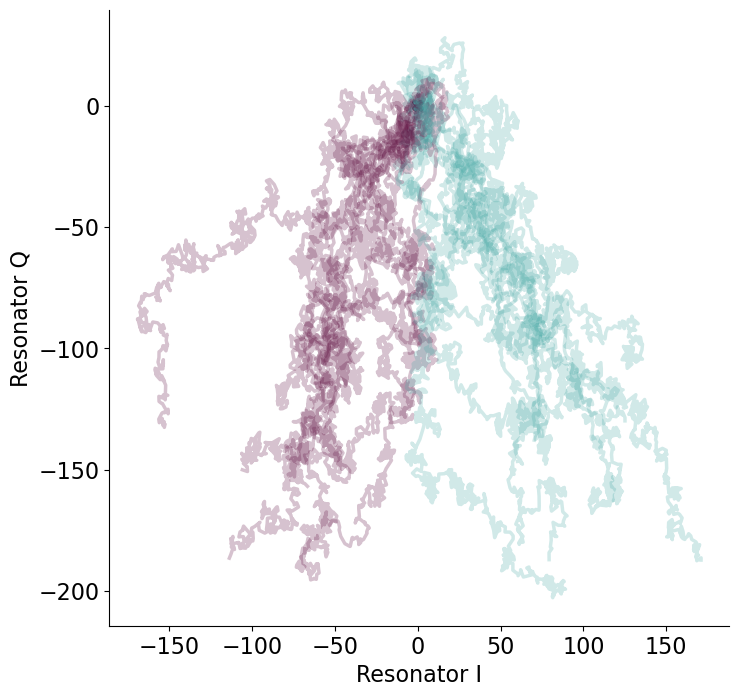

In [158]:
plot_IQ_trajectory(result_ground_stochastic.expect[2:], result_excited_stochastic.expect[2:], plot_every = 100)

for i in range(result_ground_stochastic.ntraj):
    plt.plot(rolling_mean(result_ground_stochastic.measurement[i][:, 0, 0]), rolling_mean(result_ground_stochastic.measurement[i][:,0, 1]), color = "C0", alpha = 0.25)
    plt.plot(rolling_mean(result_excited_stochastic.measurement[i][:, 0, 0]), rolling_mean(result_excited_stochastic.measurement[i][:,0, 1]), color = "C1", alpha = 0.25)

## trying built in heterodyne measurements

In [169]:
from qutip import vector_to_operator, lindblad_dissipator, spre, spost, liouvillian, qeye
from qutip.expect import expect_rho_vec

from qutip import smesolve

qubit_decay =         tensor(qubit_decay_operator,        qutip.qeye(resonator_states))
qubit_excitation =    tensor(qubit_excite_operator,       qutip.qeye(resonator_states))
photon_decay =        tensor(qutip.qeye(qubit_states),    destroy(resonator_states))


result_ground_stochastic = smesolve(
    H,
    ket2dm(tensor(ground_qubit_state, ground_resonator_state)),
    tlist,
    c_ops  = [qubit_decay, qubit_excitation],
    sc_ops = [np.sqrt(readout_photon_rate) * photon_decay],
    e_ops = e_ops,
    progress_bar = True,
    ntraj = 10,
    method = "heterodyne",
    store_measurement = True,
    map_func = parallel_map,
    dW_factors = [1],
    solver = "taylor15"
)

result_excited_stochastic = smesolve(
    H,
    ket2dm(tensor(excited_qubit_state, ground_resonator_state)),
    tlist,
    c_ops  = [qubit_decay, qubit_excitation],
    sc_ops = [np.sqrt(readout_photon_rate) * photon_decay],
    e_ops = e_ops,
    ntraj = 10,
    progress_bar = True,
    method = "heterodyne",
    store_measurement = True,
    map_func = parallel_map,
    dW_factors = [1],
    solver = "taylor15"
)


10.0%. Run time:  24.98s. Est. time left: 00:00:03:44
20.0%. Run time:  25.11s. Est. time left: 00:00:01:40
30.0%. Run time:  25.16s. Est. time left: 00:00:00:58
40.0%. Run time:  25.29s. Est. time left: 00:00:00:37
50.0%. Run time:  25.79s. Est. time left: 00:00:00:25
60.0%. Run time:  25.95s. Est. time left: 00:00:00:17
70.0%. Run time:  26.07s. Est. time left: 00:00:00:11
80.0%. Run time:  26.15s. Est. time left: 00:00:00:06
90.0%. Run time:  26.41s. Est. time left: 00:00:00:02
100.0%. Run time:  26.44s. Est. time left: 00:00:00:00
Total run time:  26.48s
10.0%. Run time:  25.08s. Est. time left: 00:00:03:45
20.0%. Run time:  25.30s. Est. time left: 00:00:01:41
30.0%. Run time:  25.99s. Est. time left: 00:00:01:00
40.0%. Run time:  27.33s. Est. time left: 00:00:00:40
50.0%. Run time:  27.62s. Est. time left: 00:00:00:27
60.0%. Run time:  27.87s. Est. time left: 00:00:00:18
70.0%. Run time:  27.94s. Est. time left: 00:00:00:11
80.0%. Run time:  28.02s. Est. time left: 00:00:00:07
90.

In [175]:
np.array(result_ground_stochastic.measurement).shape

(10, 1001, 1, 2)

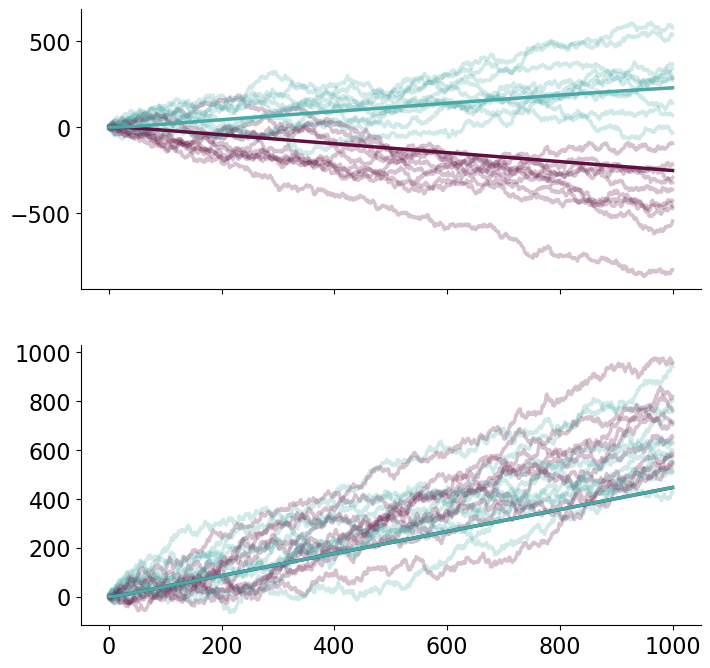

In [176]:
fig, axes = plt.subplots(nrows = 2, figsize = (8, 8), sharex = True)


def rolling_mean(array, window = 1000):
    return np.cumsum(array)
    return np.convolve(array, np.ones(window) / window, mode = "same")


for i in range(result_ground_stochastic.ntraj):
    axes[0].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_ground_stochastic.measurement[i][:,  0, 0]),  color = "C0", alpha = 0.25)
    axes[0].plot(tlist, np.sqrt(2 / readout_photon_rate) * rolling_mean(result_excited_stochastic.measurement[i][:, 0, 0]), color = "C1", alpha = 0.25)

    axes[1].plot(tlist, - np.sqrt(2 / readout_photon_rate) * rolling_mean(result_ground_stochastic.measurement[i][:, 0, 1]),  color = "C0", alpha = 0.25)
    axes[1].plot(tlist, - np.sqrt(2 / readout_photon_rate) * rolling_mean(result_excited_stochastic.measurement[i][:,0,  1]), color = "C1", alpha = 0.25)

axes[0].plot(tlist, rolling_mean(result_ground_stochastic.expect[2]),  color = "C0", label = "Ground")
axes[0].plot(tlist, rolling_mean(result_excited_stochastic.expect[2]), color = "C1", label = "Excited")

axes[1].plot(tlist, rolling_mean(result_ground_stochastic.expect[3]),  color = "C0", label = "Ground")
axes[1].plot(tlist, rolling_mean(result_excited_stochastic.expect[3]), color = "C1", label = "Excited")